# Exploration of API Data
First look at minutly data of Fronius Solar API.

## Prerequisits
- localize timestamps to "Europe/Berlin"
- transform data to kwh

In [1]:
import toml
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (14, 8)

conf = '../../conf.toml'
conn = 'postgresql://{user}:{password}@{host}:{port}/{dbname}'

def group_time(df, freq, date_format='%Y-%m-%d %H:%M:%S', kind='bar'):
    df = df.resample(freq).sum()
    df.index = df.index.strftime(date_format=date_format)
    df.plot(kind=kind, rot=45, colormap='viridis')
    plt.show()
    return df

conf = toml.load(conf)

conn = conn.format(**conf['database']['pi'])
conn = sqlalchemy.create_engine(conn)
conn = conn.connect()

kwh = pd.read_sql_table('energy_minute', conn, index_col='datetime')

kwh.index = kwh.index.tz_convert('Europe/Berlin')
kwh.index = kwh.index.tz_localize(None)
kwh = kwh.sort_index()

kwh = kwh / 1000
kwh = kwh.rename(columns={'wh': 'kwh'})

kwh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31106 entries, 2021-04-17 16:41:18 to 2021-06-04 17:58:08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kwh     31106 non-null  float64
dtypes: float64(1)
memory usage: 486.0 KB


## Time Series

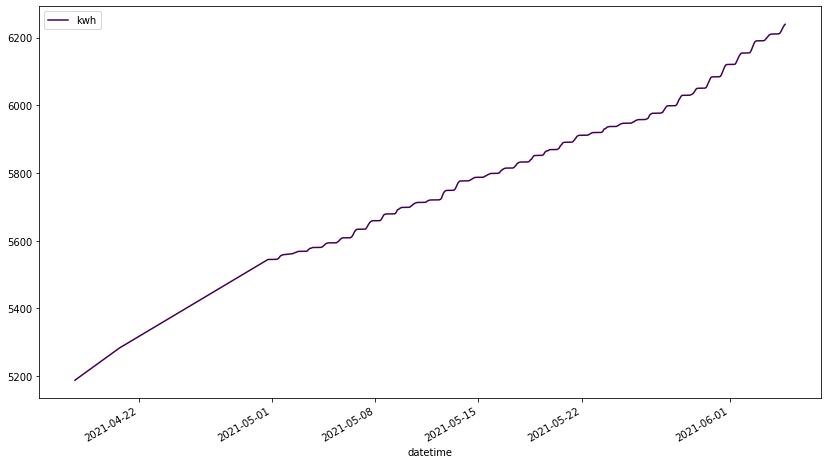

,kwh
datetime,
2021-04-17 16:41:18,5187.7300
2021-04-17 17:15:05,5188.9100
2021-04-20 16:36:18,5282.4800
2021-04-20 16:55:12,5283.2500
2021-04-30 17:33:10,5544.4800
...,...
2021-06-04 17:54:08,6239.4700
2021-06-04 17:55:09,6239.4900
2021-06-04 17:56:08,6239.5200


In [2]:
kwh.plot(colormap='viridis')
plt.show()
kwh

## Missing Values
Since May 3 the collection runs without major issues. After that the
API throws at some points still an error, but these are not so dramatic.

In [3]:
nan = pd.date_range(kwh.index[0], kwh.index[-1], freq='min').round('min')
nan = kwh.set_index(kwh.index.round('min')).reindex(nan)
nan = nan.kwh.isna() & (nan.index.hour > 5) & (nan.index.hour < 21)
nan = nan.resample('d').sum().to_frame()
nan

,kwh
2021-04-17,257
2021-04-18,900
2021-04-19,900
2021-04-20,898
2021-04-21,900
2021-04-22,900
2021-04-23,900
2021-04-24,900
2021-04-25,900
2021-04-26,900


## First Differences
- Calculate energy produced in one minute.
- Focus on days with few missing values.

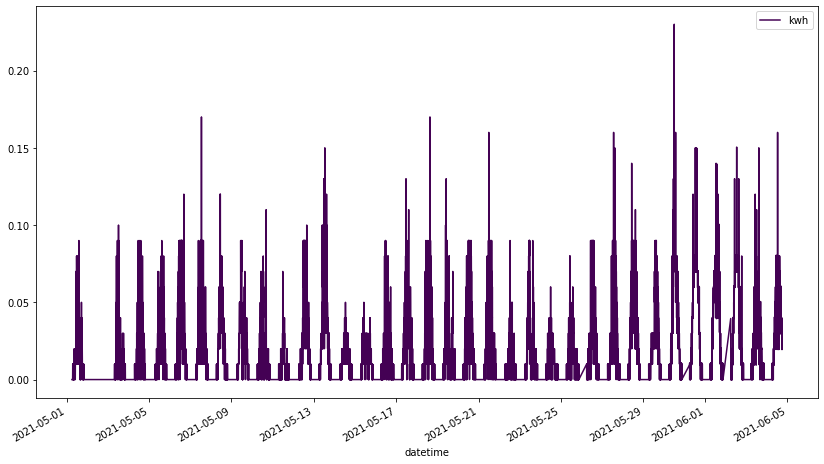

,kwh
datetime,
2021-05-01 06:00:11,0.0000
2021-05-01 06:01:09,0.0000
2021-05-01 06:02:10,0.0000
2021-05-01 06:03:10,0.0000
2021-05-01 06:04:10,0.0000
...,...
2021-06-04 17:54:08,0.0200
2021-06-04 17:55:09,0.0200
2021-06-04 17:56:08,0.0300


In [4]:
dif = kwh.diff()
dif = dif[np.isin(dif.index.date, nan[nan.kwh > 50].index.date, invert=True)]
dif.plot(colormap='viridis')
plt.show()
dif

## Distribution

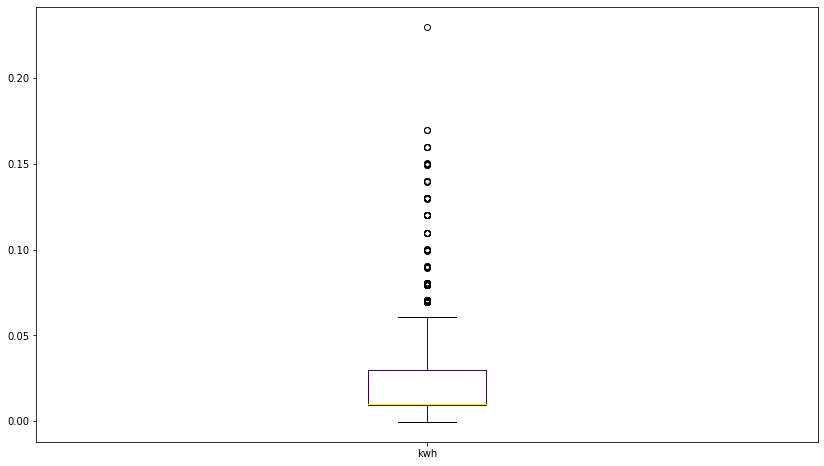

,kwh
count,30274.000000
mean,0.022625
std,0.023957
min,-0.000500
25%,0.009500
50%,0.010000
75%,0.030000
max,0.230000


In [5]:
dif.plot.box(colormap='viridis')
plt.show()
dif.describe()

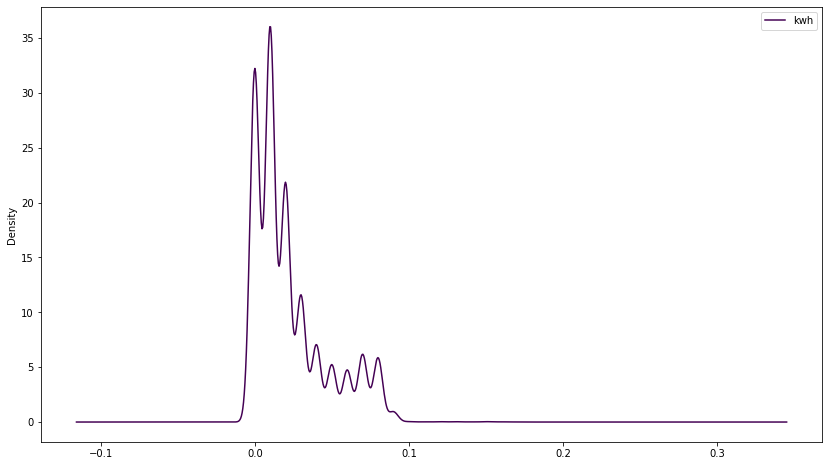

In [6]:
dif.plot.density(colormap='viridis')
plt.show()

## Aggreagate Time Series
### 15 Minutes

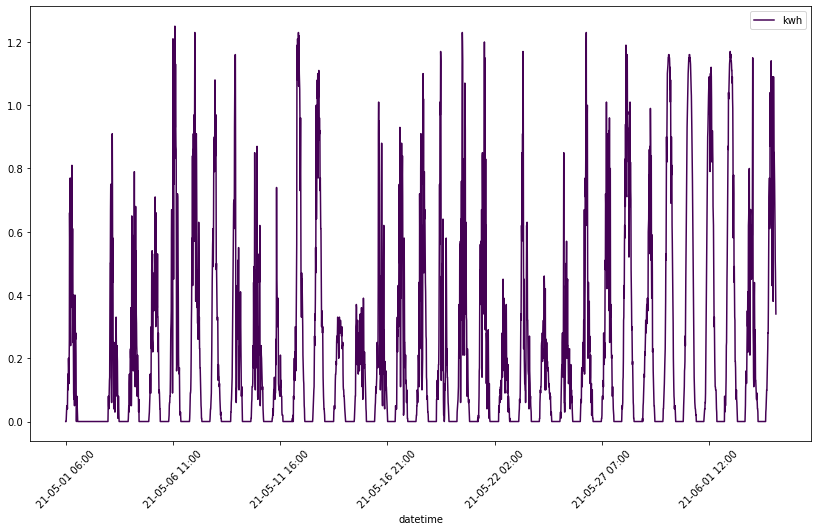

,kwh
datetime,
21-05-01 06:00,0.0000
21-05-01 06:15,0.0000
21-05-01 06:30,0.0000
21-05-01 06:45,0.0200
21-05-01 07:00,0.0400
...,...
21-06-04 16:45,0.6100
21-06-04 17:00,0.5100
21-06-04 17:15,0.4705


In [7]:
group_time(dif, '15min', '%y-%m-%d %H:%M', 'line')

### Hours

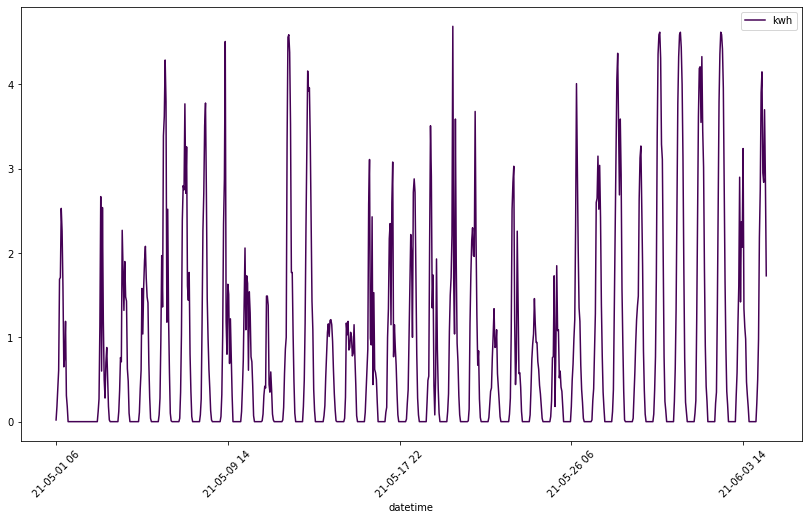

,kwh
datetime,
21-05-01 06,0.0200
21-05-01 07,0.1800
21-05-01 08,0.4000
21-05-01 09,0.6100
21-05-01 10,1.6900
...,...
21-06-04 13,2.9505
21-06-04 14,2.8395
21-06-04 15,3.7005


In [8]:
group_time(dif, 'H', '%y-%m-%d %H', 'line')

### Days

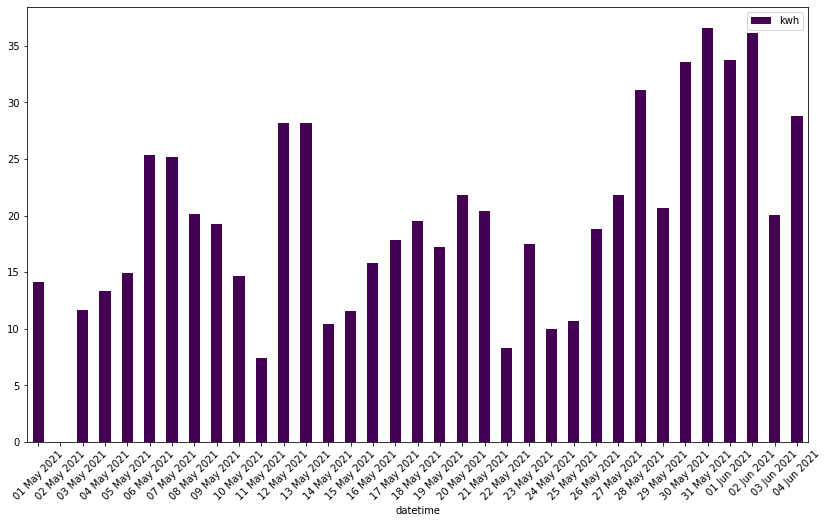

,kwh
datetime,
01 May 2021,14.1000
02 May 2021,0.0000
03 May 2021,11.6400
04 May 2021,13.3600
05 May 2021,14.9400
06 May 2021,25.3800
07 May 2021,25.1500
08 May 2021,20.1400
09 May 2021,19.2200


In [9]:
group_time(dif, 'd', '%d %b %Y')

### Weeks

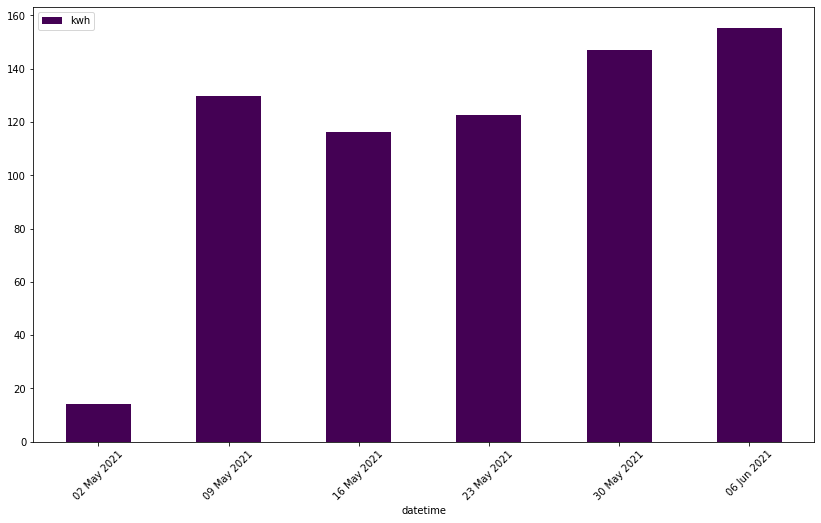

,kwh
datetime,
02 May 2021,14.1000
09 May 2021,129.8300
16 May 2021,116.1700
23 May 2021,122.6900
30 May 2021,146.7800
06 Jun 2021,155.3695


In [10]:
group_time(dif, 'W', '%d %b %Y')

### Months

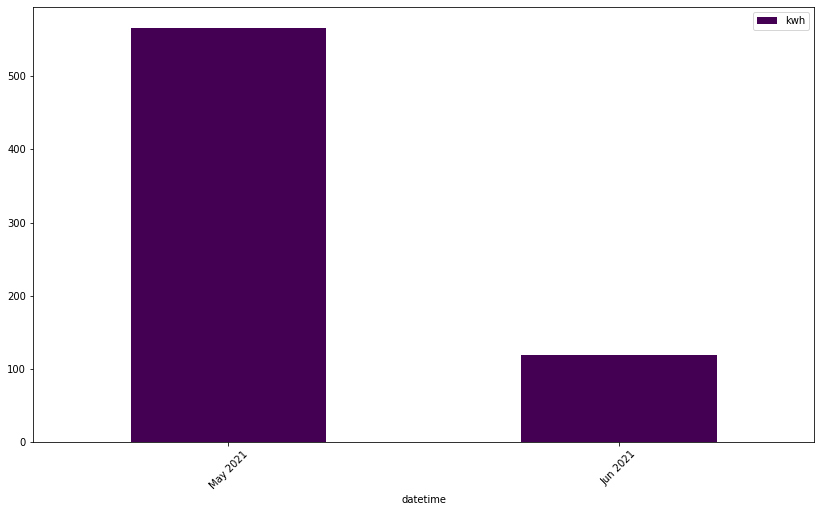

,kwh
datetime,
May 2021,566.1900
Jun 2021,118.7495


In [11]:
group_time(dif, 'm', '%b %Y')

### Years

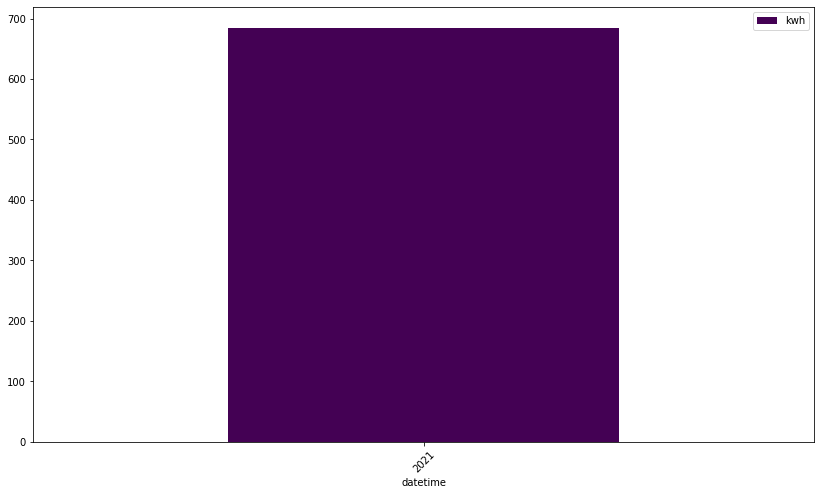

,kwh
datetime,
2021,684.9395


In [12]:
group_time(dif, 'y', '%Y')